In [1]:
import scipy.io
import tensorflow as tf   # tested with tf 1.15.3
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 60000 # number of training steps
iteration = 5 # number of iterations (iid runs based on available files, data shuffled and subsampled at 80%)
d = 16 # dimensions aka proteins
mb_size = 4000 # batch size
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
w = 0.2 # sick cell contamination
print(steps)
print(iteration)
print(d)
print(mb_size)


60000
5
16
4000


In [3]:
# hyperparameters
if d==6:                       
    layers = [d, 16, 16, 1] 
elif d==15:                       
    layers = [d, 16, 16, 1] 
elif d==2:
    layers = [d, 16, 16, 8, 1]
elif d==10:
    layers = [d, 16, 16, 8, 1]#[d, 32, 32, 16, 1]
elif d == 16:
    layers = [d, 16, 16, 8, 1]
elif d==50:
    layers = [d, 64, 64, 32, 1]
elif d==1:                     
    layers = [d, 8, 8, 4, 1]
else:
    raise Exception("Check dimension and layers...")

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = 5.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 5.0) # bound M=5

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(alpha_range), iteration)) 
D_loss_vals_w_005 =  np.zeros(shape=(len(alpha_range), iteration)) 


In [6]:
# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, alpha_i in enumerate(alpha_range): 
    
    print('j=', j)

    #alpha = alpha_range
    #No_alpha = len(alpha_range)

    
    beta = lam*(1-alpha_i)  
    gamma = lam*alpha_i  
    
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    D_solver = tf.train.AdamOptimizer(learning_rate=0.01).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_20perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/H3_H4_H5_H6_H7_vs_CBF_perc4_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

        
        
# w=0.05
    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())
        
        # load data
        file_id = iter + 1 
        fname = 'data/all_Healthy_vs_CBF_0.5perc_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16/input_files_N39000/H3_H4_H5_H6_H7_HALF_SAMPLES_vs_CBF_perc5_markers_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_'
        data = scipy.io.loadmat(fname + 'iter_'+str(file_id)+'.mat')
        # SWAPPED X<->Y (Y is CBF)
        x = np.array(data['Y'])
        y = np.array(data['X'])

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals_w_005[j,iter] = -lam * D_loss_curr
        
        
""" 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_real_data_BS_plots/'):
        os.makedirs('data/out_real_data_BS_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_real_data_BS_plots/cgan_Dloss' + str(j) + 'alpha_' + str(alpha_i) +'.png', bbox_inches='tight')
    plt.close(fig)
"""       

j= 0
Iteration: 0
Iter: 0
Renyi divergence: -1.0927396942861378e-05

Iter: 1000
Renyi divergence: 0.2095339298248291

Iter: 2000
Renyi divergence: 0.2276163101196289

Iter: 3000
Renyi divergence: 0.22355079650878906

Iter: 4000
Renyi divergence: 0.21627569198608398

Iter: 5000
Renyi divergence: 0.2375330924987793

Iter: 6000
Renyi divergence: 0.23089933395385742

Iter: 7000
Renyi divergence: 0.2420182228088379

Iter: 8000
Renyi divergence: 0.24269819259643555

Iter: 9000
Renyi divergence: 0.24180984497070312

Iter: 10000
Renyi divergence: 0.2450733184814453

Iter: 11000
Renyi divergence: 0.24254655838012695

Iter: 12000
Renyi divergence: 0.2638864517211914

Iter: 13000
Renyi divergence: 0.2537388801574707

Iter: 14000
Renyi divergence: 0.24201583862304688

Iter: 15000
Renyi divergence: 0.24094724655151367

Iter: 16000
Renyi divergence: 0.24849891662597656

Iter: 17000
Renyi divergence: 0.25600433349609375

Iter: 18000
Renyi divergence: 0.24712276458740234

Iter: 19000
Renyi divergence:

Iter: 42000
Renyi divergence: 0.23730897903442383

Iter: 43000
Renyi divergence: 0.25324392318725586

Iter: 44000
Renyi divergence: 0.23377513885498047

Iter: 45000
Renyi divergence: 0.25234222412109375

Iter: 46000
Renyi divergence: 0.2537689208984375

Iter: 47000
Renyi divergence: 0.24112796783447266

Iter: 48000
Renyi divergence: 0.24138879776000977

Iter: 49000
Renyi divergence: 0.2445077896118164

Iter: 50000
Renyi divergence: 0.26299047470092773

Iter: 51000
Renyi divergence: 0.23817110061645508

Iter: 52000
Renyi divergence: 0.25070762634277344

Iter: 53000
Renyi divergence: 0.24312448501586914

Iter: 54000
Renyi divergence: 0.2466568946838379

Iter: 55000
Renyi divergence: 0.2317519187927246

Iter: 56000
Renyi divergence: 0.2554464340209961

Iter: 57000
Renyi divergence: 0.24155473709106445

Iter: 58000
Renyi divergence: 0.2511739730834961

Iter: 59000
Renyi divergence: 0.25180482864379883

Iteration: 3
Iter: 0
Renyi divergence: -3.353953070472926e-05

Iter: 1000
Renyi divergen

Iter: 24000
Renyi divergence: 0.027890920639038086

Iter: 25000
Renyi divergence: 0.017730712890625

Iter: 26000
Renyi divergence: 0.02112889289855957

Iter: 27000
Renyi divergence: 0.029308199882507324

Iter: 28000
Renyi divergence: 0.016626596450805664

Iter: 29000
Renyi divergence: 0.01671469211578369

Iter: 30000
Renyi divergence: 0.02044987678527832

Iter: 31000
Renyi divergence: 0.023429155349731445

Iter: 32000
Renyi divergence: 0.017853379249572754

Iter: 33000
Renyi divergence: 0.02281665802001953

Iter: 34000
Renyi divergence: 0.02209627628326416

Iter: 35000
Renyi divergence: 0.0217515230178833

Iter: 36000
Renyi divergence: 0.028540492057800293

Iter: 37000
Renyi divergence: 0.029990673065185547

Iter: 38000
Renyi divergence: 0.020804882049560547

Iter: 39000
Renyi divergence: 0.025187015533447266

Iter: 40000
Renyi divergence: 0.02726125717163086

Iter: 41000
Renyi divergence: 0.024666547775268555

Iter: 42000
Renyi divergence: 0.017721176147460938

Iter: 43000
Renyi diver

Iter: 3000
Renyi divergence: 0.03469061851501465

Iter: 4000
Renyi divergence: 0.03307604789733887

Iter: 5000
Renyi divergence: 0.016623735427856445

Iter: 6000
Renyi divergence: 0.01684093475341797

Iter: 7000
Renyi divergence: 0.011087536811828613

Iter: 8000
Renyi divergence: 0.005839556455612183

Iter: 9000
Renyi divergence: 0.015276670455932617

Iter: 10000
Renyi divergence: 0.0028209686279296875

Iter: 11000
Renyi divergence: 0.0178067684173584

Iter: 12000
Renyi divergence: 0.012619495391845703

Iter: 13000
Renyi divergence: 0.007871866226196289

Iter: 14000
Renyi divergence: 0.015424847602844238

Iter: 15000
Renyi divergence: 0.018953800201416016

Iter: 16000
Renyi divergence: 0.00999307632446289

Iter: 17000
Renyi divergence: 0.01727759838104248

Iter: 18000
Renyi divergence: 0.010424137115478516

Iter: 19000
Renyi divergence: 0.01745891571044922

Iter: 20000
Renyi divergence: 0.019977450370788574

Iter: 21000
Renyi divergence: 0.012603759765625

Iter: 22000
Renyi divergence:

Iter: 43000
Renyi divergence: 0.27694129943847656

Iter: 44000
Renyi divergence: 0.2842545509338379

Iter: 45000
Renyi divergence: 0.2830815315246582

Iter: 46000
Renyi divergence: 0.2651824951171875

Iter: 47000
Renyi divergence: 0.2583761215209961

Iter: 48000
Renyi divergence: 0.28957700729370117

Iter: 49000
Renyi divergence: 0.28662967681884766

Iter: 50000
Renyi divergence: 0.27283477783203125

Iter: 51000
Renyi divergence: 0.27809906005859375

Iter: 52000
Renyi divergence: 0.28260040283203125

Iter: 53000
Renyi divergence: 0.28208398818969727

Iter: 54000
Renyi divergence: 0.270082950592041

Iter: 55000
Renyi divergence: 0.2925748825073242

Iter: 56000
Renyi divergence: 0.2693166732788086

Iter: 57000
Renyi divergence: 0.2732400894165039

Iter: 58000
Renyi divergence: 0.30214691162109375

Iter: 59000
Renyi divergence: 0.29254961013793945

Iteration: 1
Iter: 0
Renyi divergence: 8.693983545526862e-05

Iter: 1000
Renyi divergence: 0.2509627342224121

Iter: 2000
Renyi divergence: 0.

Iter: 26000
Renyi divergence: 0.27399206161499023

Iter: 27000
Renyi divergence: 0.2668571472167969

Iter: 28000
Renyi divergence: 0.27437400817871094

Iter: 29000
Renyi divergence: 0.2754688262939453

Iter: 30000
Renyi divergence: 0.28382349014282227

Iter: 31000
Renyi divergence: 0.2704148292541504

Iter: 32000
Renyi divergence: 0.26848316192626953

Iter: 33000
Renyi divergence: 0.27503395080566406

Iter: 34000
Renyi divergence: 0.2698197364807129

Iter: 35000
Renyi divergence: 0.26321887969970703

Iter: 36000
Renyi divergence: 0.2685275077819824

Iter: 37000
Renyi divergence: 0.2624092102050781

Iter: 38000
Renyi divergence: 0.2737712860107422

Iter: 39000
Renyi divergence: 0.27945804595947266

Iter: 40000
Renyi divergence: 0.25688743591308594

Iter: 41000
Renyi divergence: 0.25682640075683594

Iter: 42000
Renyi divergence: 0.28014087677001953

Iter: 43000
Renyi divergence: 0.29157400131225586

Iter: 44000
Renyi divergence: 0.26142215728759766

Iter: 45000
Renyi divergence: 0.272796

Iter: 7000
Renyi divergence: 0.022036075592041016

Iter: 8000
Renyi divergence: 0.030728816986083984

Iter: 9000
Renyi divergence: 0.022054195404052734

Iter: 10000
Renyi divergence: 0.027336835861206055

Iter: 11000
Renyi divergence: 0.010826587677001953

Iter: 12000
Renyi divergence: 0.011059045791625977

Iter: 13000
Renyi divergence: 0.017993450164794922

Iter: 14000
Renyi divergence: 0.034384727478027344

Iter: 15000
Renyi divergence: 0.022196054458618164

Iter: 16000
Renyi divergence: 0.014316558837890625

Iter: 17000
Renyi divergence: -0.011745452880859375

Iter: 18000
Renyi divergence: 0.01656055450439453

Iter: 19000
Renyi divergence: 0.019155025482177734

Iter: 20000
Renyi divergence: 0.012190937995910645

Iter: 21000
Renyi divergence: 0.00900280475616455

Iter: 22000
Renyi divergence: 0.020453572273254395

Iter: 23000
Renyi divergence: 0.01932835578918457

Iter: 24000
Renyi divergence: 0.0195772647857666

Iter: 25000
Renyi divergence: 0.018381834030151367

Iter: 26000
Renyi d

Iter: 47000
Renyi divergence: 0.010419368743896484

Iter: 48000
Renyi divergence: 0.015973567962646484

Iter: 49000
Renyi divergence: 0.020148873329162598

Iter: 50000
Renyi divergence: 0.017154693603515625

Iter: 51000
Renyi divergence: 0.022060692310333252

Iter: 52000
Renyi divergence: 0.014596700668334961

Iter: 53000
Renyi divergence: 0.010417699813842773

Iter: 54000
Renyi divergence: 0.024199843406677246

Iter: 55000
Renyi divergence: 0.007244586944580078

Iter: 56000
Renyi divergence: 0.017380118370056152

Iter: 57000
Renyi divergence: 0.03037238121032715

Iter: 58000
Renyi divergence: 0.017304658889770508

Iter: 59000
Renyi divergence: 0.011899948120117188

Iteration: 4
Iter: 0
Renyi divergence: 8.237781003117561e-06

Iter: 1000
Renyi divergence: 0.017519593238830566

Iter: 2000
Renyi divergence: 0.01497793197631836

Iter: 3000
Renyi divergence: 0.030212879180908203

Iter: 4000
Renyi divergence: 0.027297019958496094

Iter: 5000
Renyi divergence: 0.023736000061035156

Iter: 600

Iter: 28000
Renyi divergence: 0.2921156883239746

Iter: 29000
Renyi divergence: 0.30219078063964844

Iter: 30000
Renyi divergence: 0.2973484992980957

Iter: 31000
Renyi divergence: 0.2968621253967285

Iter: 32000
Renyi divergence: 0.2838273048400879

Iter: 33000
Renyi divergence: 0.31141185760498047

Iter: 34000
Renyi divergence: 0.2846078872680664

Iter: 35000
Renyi divergence: 0.3055253028869629

Iter: 36000
Renyi divergence: 0.31104087829589844

Iter: 37000
Renyi divergence: 0.29383420944213867

Iter: 38000
Renyi divergence: 0.30617237091064453

Iter: 39000
Renyi divergence: 0.3070955276489258

Iter: 40000
Renyi divergence: 0.3051729202270508

Iter: 41000
Renyi divergence: 0.31166791915893555

Iter: 42000
Renyi divergence: 0.2813529968261719

Iter: 43000
Renyi divergence: 0.31099891662597656

Iter: 44000
Renyi divergence: 0.2947874069213867

Iter: 45000
Renyi divergence: 0.2809176445007324

Iter: 46000
Renyi divergence: 0.31322193145751953

Iter: 47000
Renyi divergence: 0.2963271141

Iter: 11000
Renyi divergence: 0.3080921173095703

Iter: 12000
Renyi divergence: 0.27721166610717773

Iter: 13000
Renyi divergence: 0.3083076477050781

Iter: 14000
Renyi divergence: 0.3068108558654785

Iter: 15000
Renyi divergence: 0.28713512420654297

Iter: 16000
Renyi divergence: 0.31020450592041016

Iter: 17000
Renyi divergence: 0.3046708106994629

Iter: 18000
Renyi divergence: 0.30985307693481445

Iter: 19000
Renyi divergence: 0.3045792579650879

Iter: 20000
Renyi divergence: 0.31563711166381836

Iter: 21000
Renyi divergence: 0.3028740882873535

Iter: 22000
Renyi divergence: 0.29171323776245117

Iter: 23000
Renyi divergence: 0.32378578186035156

Iter: 24000
Renyi divergence: 0.28044795989990234

Iter: 25000
Renyi divergence: 0.3023061752319336

Iter: 26000
Renyi divergence: 0.31563663482666016

Iter: 27000
Renyi divergence: 0.30435991287231445

Iter: 28000
Renyi divergence: 0.31854915618896484

Iter: 29000
Renyi divergence: 0.3258652687072754

Iter: 30000
Renyi divergence: 0.3045916

Iter: 52000
Renyi divergence: 0.0355147123336792

Iter: 53000
Renyi divergence: 0.06163036823272705

Iter: 54000
Renyi divergence: 0.05386853218078613

Iter: 55000
Renyi divergence: 0.017542719841003418

Iter: 56000
Renyi divergence: 0.05321967601776123

Iter: 57000
Renyi divergence: 0.04069209098815918

Iter: 58000
Renyi divergence: 0.05003654956817627

Iter: 59000
Renyi divergence: 0.04662132263183594

Iteration: 2
Iter: 0
Renyi divergence: -2.1382002159953117e-06

Iter: 1000
Renyi divergence: 0.014035463333129883

Iter: 2000
Renyi divergence: 0.02555394172668457

Iter: 3000
Renyi divergence: 0.03230547904968262

Iter: 4000
Renyi divergence: 0.037911415100097656

Iter: 5000
Renyi divergence: 0.044844865798950195

Iter: 6000
Renyi divergence: 0.04303741455078125

Iter: 7000
Renyi divergence: 0.03824734687805176

Iter: 8000
Renyi divergence: 0.040753841400146484

Iter: 9000
Renyi divergence: 0.0507504940032959

Iter: 10000
Renyi divergence: 0.04870343208312988

Iter: 11000
Renyi diverg

Iter: 32000
Renyi divergence: 0.05699554830789566

Iter: 33000
Renyi divergence: 0.024148106575012207

Iter: 34000
Renyi divergence: 0.05114808306097984

Iter: 35000
Renyi divergence: 0.049457892775535583

Iter: 36000
Renyi divergence: 0.029589802026748657

Iter: 37000
Renyi divergence: 0.053767815232276917

Iter: 38000
Renyi divergence: 0.03518524765968323

Iter: 39000
Renyi divergence: 0.04988755285739899

Iter: 40000
Renyi divergence: 0.04843835532665253

Iter: 41000
Renyi divergence: 0.042951442301273346

Iter: 42000
Renyi divergence: 0.04256531596183777

Iter: 43000
Renyi divergence: 0.045435428619384766

Iter: 44000
Renyi divergence: 0.05180320143699646

Iter: 45000
Renyi divergence: 0.031792283058166504

Iter: 46000
Renyi divergence: 0.04762311279773712

Iter: 47000
Renyi divergence: 0.03001415729522705

Iter: 48000
Renyi divergence: 0.04525920748710632

Iter: 49000
Renyi divergence: 0.017169475555419922

Iter: 50000
Renyi divergence: 0.033429861068725586

Iter: 51000
Renyi dive

Iter: 14000
Renyi divergence: 0.34528207778930664

Iter: 15000
Renyi divergence: 0.34552717208862305

Iter: 16000
Renyi divergence: 0.3713831901550293

Iter: 17000
Renyi divergence: 0.37349367141723633

Iter: 18000
Renyi divergence: 0.3629169464111328

Iter: 19000
Renyi divergence: 0.3644075393676758

Iter: 20000
Renyi divergence: 0.3224601745605469

Iter: 21000
Renyi divergence: 0.3532724380493164

Iter: 22000
Renyi divergence: 0.36200523376464844

Iter: 23000
Renyi divergence: 0.33943748474121094

Iter: 24000
Renyi divergence: 0.32800912857055664

Iter: 25000
Renyi divergence: 0.37748146057128906

Iter: 26000
Renyi divergence: 0.37989139556884766

Iter: 27000
Renyi divergence: 0.3500537872314453

Iter: 28000
Renyi divergence: 0.34013938903808594

Iter: 29000
Renyi divergence: 0.37836313247680664

Iter: 30000
Renyi divergence: 0.331451416015625

Iter: 31000
Renyi divergence: 0.34636926651000977

Iter: 32000
Renyi divergence: 0.34289979934692383

Iter: 33000
Renyi divergence: 0.3628478

Iter: 57000
Renyi divergence: 0.3671231269836426

Iter: 58000
Renyi divergence: 0.3637228012084961

Iter: 59000
Renyi divergence: 0.365323543548584

Iteration: 0
Iter: 0
Renyi divergence: 7.688184268772602e-06

Iter: 1000
Renyi divergence: 0.012671470642089844

Iter: 2000
Renyi divergence: 0.021277189254760742

Iter: 3000
Renyi divergence: 0.020111560821533203

Iter: 4000
Renyi divergence: 0.03370833396911621

Iter: 5000
Renyi divergence: 0.03608298301696777

Iter: 6000
Renyi divergence: 0.04663586616516113

Iter: 7000
Renyi divergence: 0.04863476753234863

Iter: 8000
Renyi divergence: 0.04434633255004883

Iter: 9000
Renyi divergence: 0.04427063465118408

Iter: 10000
Renyi divergence: 0.06205260753631592

Iter: 11000
Renyi divergence: 0.05724155902862549

Iter: 12000
Renyi divergence: 0.06531941890716553

Iter: 13000
Renyi divergence: 0.060710787773132324

Iter: 14000
Renyi divergence: 0.0470433235168457

Iter: 15000
Renyi divergence: 0.05531430244445801

Iter: 16000
Renyi divergence: 

Iter: 38000
Renyi divergence: 0.05574573576450348

Iter: 39000
Renyi divergence: 0.061698466539382935

Iter: 40000
Renyi divergence: 0.07646238803863525

Iter: 41000
Renyi divergence: 0.052880048751831055

Iter: 42000
Renyi divergence: 0.07764139771461487

Iter: 43000
Renyi divergence: 0.0688973069190979

Iter: 44000
Renyi divergence: 0.059885174036026

Iter: 45000
Renyi divergence: 0.07292070984840393

Iter: 46000
Renyi divergence: 0.08466958999633789

Iter: 47000
Renyi divergence: 0.05223524570465088

Iter: 48000
Renyi divergence: 0.07087428867816925

Iter: 49000
Renyi divergence: 0.07697127759456635

Iter: 50000
Renyi divergence: 0.08149653673171997

Iter: 51000
Renyi divergence: 0.0698276162147522

Iter: 52000
Renyi divergence: 0.07692575454711914

Iter: 53000
Renyi divergence: 0.06170135736465454

Iter: 54000
Renyi divergence: 0.056632041931152344

Iter: 55000
Renyi divergence: 0.05389690399169922

Iter: 56000
Renyi divergence: 0.0899224504828453

Iter: 57000
Renyi divergence: 0.0

Iter: 19000
Renyi divergence: 0.4207282066345215

Iter: 20000
Renyi divergence: 0.40340232849121094

Iter: 21000
Renyi divergence: 0.43381166458129883

Iter: 22000
Renyi divergence: 0.43703365325927734

Iter: 23000
Renyi divergence: 0.4074430465698242

Iter: 24000
Renyi divergence: 0.3633451461791992

Iter: 25000
Renyi divergence: 0.4462771415710449

Iter: 26000
Renyi divergence: 0.39952564239501953

Iter: 27000
Renyi divergence: 0.42058420181274414

Iter: 28000
Renyi divergence: 0.3915901184082031

Iter: 29000
Renyi divergence: 0.3961677551269531

Iter: 30000
Renyi divergence: 0.4080162048339844

Iter: 31000
Renyi divergence: 0.42047739028930664

Iter: 32000
Renyi divergence: 0.4428286552429199

Iter: 33000
Renyi divergence: 0.4201655387878418

Iter: 34000
Renyi divergence: 0.4055814743041992

Iter: 35000
Renyi divergence: 0.4234437942504883

Iter: 36000
Renyi divergence: 0.40937185287475586

Iter: 37000
Renyi divergence: 0.41382694244384766

Iter: 38000
Renyi divergence: 0.4170455932

Iter: 1000
Renyi divergence: 0.38263654708862305

Iter: 2000
Renyi divergence: 0.3910083770751953

Iter: 3000
Renyi divergence: 0.3674964904785156

Iter: 4000
Renyi divergence: 0.4160041809082031

Iter: 5000
Renyi divergence: 0.39263105392456055

Iter: 6000
Renyi divergence: 0.39478397369384766

Iter: 7000
Renyi divergence: 0.4062771797180176

Iter: 8000
Renyi divergence: 0.3942551612854004

Iter: 9000
Renyi divergence: 0.3750762939453125

Iter: 10000
Renyi divergence: 0.4102182388305664

Iter: 11000
Renyi divergence: 0.37433433532714844

Iter: 12000
Renyi divergence: 0.3885197639465332

Iter: 13000
Renyi divergence: 0.42659568786621094

Iter: 14000
Renyi divergence: 0.44611072540283203

Iter: 15000
Renyi divergence: 0.41916704177856445

Iter: 16000
Renyi divergence: 0.38649559020996094

Iter: 17000
Renyi divergence: 0.40260791778564453

Iter: 18000
Renyi divergence: 0.44215869903564453

Iter: 19000
Renyi divergence: 0.4215579032897949

Iter: 20000
Renyi divergence: 0.3963613510131836


Iter: 44000
Renyi divergence: 0.07714366912841797

Iter: 45000
Renyi divergence: 0.07244729995727539

Iter: 46000
Renyi divergence: 0.059499263763427734

Iter: 47000
Renyi divergence: 0.012938499450683594

Iter: 48000
Renyi divergence: 0.03491806983947754

Iter: 49000
Renyi divergence: 0.03684520721435547

Iter: 50000
Renyi divergence: 0.047623634338378906

Iter: 51000
Renyi divergence: 0.04214942455291748

Iter: 52000
Renyi divergence: 0.036800503730773926

Iter: 53000
Renyi divergence: 0.028317809104919434

Iter: 54000
Renyi divergence: 0.040510714054107666

Iter: 55000
Renyi divergence: 0.044347167015075684

Iter: 56000
Renyi divergence: 0.03978109359741211

Iter: 57000
Renyi divergence: 0.04384118318557739

Iter: 58000
Renyi divergence: 0.04455059766769409

Iter: 59000
Renyi divergence: 0.0443042516708374

Iteration: 1
Iter: 0
Renyi divergence: -1.0641408152878284e-05

Iter: 1000
Renyi divergence: 0.010273933410644531

Iter: 2000
Renyi divergence: 0.022370338439941406

Iter: 3000
R

Iter: 25000
Renyi divergence: 0.049365997314453125

Iter: 26000
Renyi divergence: 0.05532550811767578

Iter: 27000
Renyi divergence: 0.050043344497680664

Iter: 28000
Renyi divergence: 0.046506643295288086

Iter: 29000
Renyi divergence: 0.05505251884460449

Iter: 30000
Renyi divergence: 0.044615745544433594

Iter: 31000
Renyi divergence: 0.041673898696899414

Iter: 32000
Renyi divergence: 0.05955791473388672

Iter: 33000
Renyi divergence: 0.03474235534667969

Iter: 34000
Renyi divergence: 0.04856729507446289

Iter: 35000
Renyi divergence: 0.04668426513671875

Iter: 36000
Renyi divergence: 0.0627584457397461

Iter: 37000
Renyi divergence: 0.04727888107299805

Iter: 38000
Renyi divergence: 0.04211902618408203

Iter: 39000
Renyi divergence: 0.0634915828704834

Iter: 40000
Renyi divergence: 0.05070972442626953

Iter: 41000
Renyi divergence: 0.06711816787719727

Iter: 42000
Renyi divergence: 0.0711050033569336

Iter: 43000
Renyi divergence: 0.07782173156738281

Iter: 44000
Renyi divergence:

Iter: 6000
Renyi divergence: 0.48957252502441406

Iter: 7000
Renyi divergence: 0.49686098098754883

Iter: 8000
Renyi divergence: 0.5024785995483398

Iter: 9000
Renyi divergence: 0.47193384170532227

Iter: 10000
Renyi divergence: 0.47446346282958984

Iter: 11000
Renyi divergence: 0.5025639533996582

Iter: 12000
Renyi divergence: 0.49345922470092773

Iter: 13000
Renyi divergence: 0.46213865280151367

Iter: 14000
Renyi divergence: 0.48141050338745117

Iter: 15000
Renyi divergence: 0.5091829299926758

Iter: 16000
Renyi divergence: 0.5248756408691406

Iter: 17000
Renyi divergence: 0.5210666656494141

Iter: 18000
Renyi divergence: 0.4774603843688965

Iter: 19000
Renyi divergence: 0.4626150131225586

Iter: 20000
Renyi divergence: 0.5030360221862793

Iter: 21000
Renyi divergence: 0.49094343185424805

Iter: 22000
Renyi divergence: 0.4914412498474121

Iter: 23000
Renyi divergence: 0.48713016510009766

Iter: 24000
Renyi divergence: 0.5008201599121094

Iter: 25000
Renyi divergence: 0.5155959129333

Iter: 50000
Renyi divergence: 0.545842170715332

Iter: 51000
Renyi divergence: 0.4963111877441406

Iter: 52000
Renyi divergence: 0.5060214996337891

Iter: 53000
Renyi divergence: 0.4985976219177246

Iter: 54000
Renyi divergence: 0.5268735885620117

Iter: 55000
Renyi divergence: 0.4843873977661133

Iter: 56000
Renyi divergence: 0.4450187683105469

Iter: 57000
Renyi divergence: 0.46424150466918945

Iter: 58000
Renyi divergence: 0.5154619216918945

Iter: 59000
Renyi divergence: 0.5125231742858887

Iteration: 4
Iter: 0
Renyi divergence: -0.00021543027833104134

Iter: 1000
Renyi divergence: 0.4139890670776367

Iter: 2000
Renyi divergence: 0.46808338165283203

Iter: 3000
Renyi divergence: 0.44277286529541016

Iter: 4000
Renyi divergence: 0.4694194793701172

Iter: 5000
Renyi divergence: 0.5128021240234375

Iter: 6000
Renyi divergence: 0.4841423034667969

Iter: 7000
Renyi divergence: 0.47502946853637695

Iter: 8000
Renyi divergence: 0.46573448181152344

Iter: 9000
Renyi divergence: 0.462464809

Iter: 32000
Renyi divergence: 0.04261374473571777

Iter: 33000
Renyi divergence: 0.050128936767578125

Iter: 34000
Renyi divergence: 0.04874396324157715

Iter: 35000
Renyi divergence: 0.02487969398498535

Iter: 36000
Renyi divergence: 0.05802583694458008

Iter: 37000
Renyi divergence: 0.05168890953063965

Iter: 38000
Renyi divergence: 0.0422055721282959

Iter: 39000
Renyi divergence: 0.05643153190612793

Iter: 40000
Renyi divergence: 0.057930707931518555

Iter: 41000
Renyi divergence: 0.04780101776123047

Iter: 42000
Renyi divergence: 0.057035207748413086

Iter: 43000
Renyi divergence: 0.04117298126220703

Iter: 44000
Renyi divergence: 0.01616811752319336

Iter: 45000
Renyi divergence: 0.05525469779968262

Iter: 46000
Renyi divergence: 0.0454256534576416

Iter: 47000
Renyi divergence: 0.041493892669677734

Iter: 48000
Renyi divergence: 0.057259321212768555

Iter: 49000
Renyi divergence: 0.05801987648010254

Iter: 50000
Renyi divergence: 0.04697537422180176

Iter: 51000
Renyi divergence

Iter: 12000
Renyi divergence: 0.04243302345275879

Iter: 13000
Renyi divergence: 0.019481420516967773

Iter: 14000
Renyi divergence: 0.0123291015625

Iter: 15000
Renyi divergence: 0.021512985229492188

Iter: 16000
Renyi divergence: 0.02726888656616211

Iter: 17000
Renyi divergence: 0.007212162017822266

Iter: 18000
Renyi divergence: 0.025596141815185547

Iter: 19000
Renyi divergence: 0.02242755889892578

Iter: 20000
Renyi divergence: 0.03859758377075195

Iter: 21000
Renyi divergence: 0.03915596008300781

Iter: 22000
Renyi divergence: 0.040773630142211914

Iter: 23000
Renyi divergence: 0.025185346603393555

Iter: 24000
Renyi divergence: 0.0308380126953125

Iter: 25000
Renyi divergence: 0.026823997497558594

Iter: 26000
Renyi divergence: 0.023605823516845703

Iter: 27000
Renyi divergence: 0.0352015495300293

Iter: 28000
Renyi divergence: 0.04034423828125

Iter: 29000
Renyi divergence: 0.031247854232788086

Iter: 30000
Renyi divergence: 0.04280686378479004

Iter: 31000
Renyi divergence: 0

Iter: 55000
Renyi divergence: 0.6190934181213379

Iter: 56000
Renyi divergence: 0.5908422470092773

Iter: 57000
Renyi divergence: 0.6315703392028809

Iter: 58000
Renyi divergence: 0.6290369033813477

Iter: 59000
Renyi divergence: 0.5903139114379883

Iteration: 2
Iter: 0
Renyi divergence: -1.876901660580188e-05

Iter: 1000
Renyi divergence: 0.5731821060180664

Iter: 2000
Renyi divergence: 0.4848499298095703

Iter: 3000
Renyi divergence: 0.5319337844848633

Iter: 4000
Renyi divergence: 0.6155781745910645

Iter: 5000
Renyi divergence: 0.6071219444274902

Iter: 6000
Renyi divergence: 0.5285735130310059

Iter: 7000
Renyi divergence: 0.5908327102661133

Iter: 8000
Renyi divergence: 0.5924282073974609

Iter: 9000
Renyi divergence: 0.6231746673583984

Iter: 10000
Renyi divergence: 0.5867776870727539

Iter: 11000
Renyi divergence: 0.6127662658691406

Iter: 12000
Renyi divergence: 0.586003303527832

Iter: 13000
Renyi divergence: 0.6206636428833008

Iter: 14000
Renyi divergence: 0.606345653533935

Iter: 39000
Renyi divergence: 0.605320930480957

Iter: 40000
Renyi divergence: 0.6255631446838379

Iter: 41000
Renyi divergence: 0.6399106979370117

Iter: 42000
Renyi divergence: 0.6152873039245605

Iter: 43000
Renyi divergence: 0.6643576622009277

Iter: 44000
Renyi divergence: 0.570986270904541

Iter: 45000
Renyi divergence: 0.6095366477966309

Iter: 46000
Renyi divergence: 0.6481690406799316

Iter: 47000
Renyi divergence: 0.5895705223083496

Iter: 48000
Renyi divergence: 0.5752954483032227

Iter: 49000
Renyi divergence: 0.5534491539001465

Iter: 50000
Renyi divergence: 0.5624871253967285

Iter: 51000
Renyi divergence: 0.6386027336120605

Iter: 52000
Renyi divergence: 0.6165814399719238

Iter: 53000
Renyi divergence: 0.6151165962219238

Iter: 54000
Renyi divergence: 0.6704206466674805

Iter: 55000
Renyi divergence: 0.6410918235778809

Iter: 56000
Renyi divergence: 0.6206169128417969

Iter: 57000
Renyi divergence: 0.5227603912353516

Iter: 58000
Renyi divergence: 0.6429963111877441

It

Iter: 18000
Renyi divergence: 0.018435001373291016

Iter: 19000
Renyi divergence: 0.02083301544189453

Iter: 20000
Renyi divergence: 0.021608829498291016

Iter: 21000
Renyi divergence: 0.017851591110229492

Iter: 22000
Renyi divergence: 0.010111331939697266

Iter: 23000
Renyi divergence: 0.02230215072631836

Iter: 24000
Renyi divergence: 0.016326427459716797

Iter: 25000
Renyi divergence: 0.022639751434326172

Iter: 26000
Renyi divergence: 0.01643824577331543

Iter: 27000
Renyi divergence: 0.02395319938659668

Iter: 28000
Renyi divergence: 0.029139041900634766

Iter: 29000
Renyi divergence: 0.010774612426757812

Iter: 30000
Renyi divergence: 0.02552485466003418

Iter: 31000
Renyi divergence: 0.023234844207763672

Iter: 32000
Renyi divergence: 0.033339738845825195

Iter: 33000
Renyi divergence: 0.029286861419677734

Iter: 34000
Renyi divergence: 0.018826007843017578

Iter: 35000
Renyi divergence: 0.03511786460876465

Iter: 36000
Renyi divergence: 0.015804052352905273

Iter: 37000
Renyi 

Iter: 57000
Renyi divergence: 0.020561933517456055

Iter: 58000
Renyi divergence: 0.022078514099121094

Iter: 59000
Renyi divergence: 0.019654035568237305

j= 7
Iteration: 0
Iter: 0
Renyi divergence: -0.00013130228035151958

Iter: 1000
Renyi divergence: 0.620398998260498

Iter: 2000
Renyi divergence: 0.6679491996765137

Iter: 3000
Renyi divergence: 0.7285251617431641

Iter: 4000
Renyi divergence: 0.755976676940918

Iter: 5000
Renyi divergence: 0.7321615219116211

Iter: 6000
Renyi divergence: 0.7112565040588379

Iter: 7000
Renyi divergence: 0.7564206123352051

Iter: 8000
Renyi divergence: 0.7648816108703613

Iter: 9000
Renyi divergence: 0.7440438270568848

Iter: 10000
Renyi divergence: 0.6619534492492676

Iter: 11000
Renyi divergence: 0.6976556777954102

Iter: 12000
Renyi divergence: 0.7421846389770508

Iter: 13000
Renyi divergence: 0.8065633773803711

Iter: 14000
Renyi divergence: 0.8137097358703613

Iter: 15000
Renyi divergence: 0.7420973777770996

Iter: 16000
Renyi divergence: 0.7385

Iter: 41000
Renyi divergence: 0.7582120895385742

Iter: 42000
Renyi divergence: 0.7886962890625

Iter: 43000
Renyi divergence: 0.8268141746520996

Iter: 44000
Renyi divergence: 0.8263020515441895

Iter: 45000
Renyi divergence: 0.7799239158630371

Iter: 46000
Renyi divergence: 0.7967572212219238

Iter: 47000
Renyi divergence: 0.7599797248840332

Iter: 48000
Renyi divergence: 0.8329567909240723

Iter: 49000
Renyi divergence: 0.7556381225585938

Iter: 50000
Renyi divergence: 0.8359341621398926

Iter: 51000
Renyi divergence: 0.8047800064086914

Iter: 52000
Renyi divergence: 0.7897167205810547

Iter: 53000
Renyi divergence: 0.8322820663452148

Iter: 54000
Renyi divergence: 0.7536664009094238

Iter: 55000
Renyi divergence: 0.8663039207458496

Iter: 56000
Renyi divergence: 0.832672119140625

Iter: 57000
Renyi divergence: 0.7116408348083496

Iter: 58000
Renyi divergence: 0.819939136505127

Iter: 59000
Renyi divergence: 0.7877254486083984

Iteration: 3
Iter: 0
Renyi divergence: -0.0001680786372

Iter: 24000
Renyi divergence: 0.010687112808227539

Iter: 25000
Renyi divergence: 0.00033664703369140625

Iter: 26000
Renyi divergence: 0.010264873504638672

Iter: 27000
Renyi divergence: 0.012257099151611328

Iter: 28000
Renyi divergence: 0.0017480850219726562

Iter: 29000
Renyi divergence: 0.010062694549560547

Iter: 30000
Renyi divergence: 0.016676902770996094

Iter: 31000
Renyi divergence: 0.012203216552734375

Iter: 32000
Renyi divergence: 0.008459091186523438

Iter: 33000
Renyi divergence: 0.013774871826171875

Iter: 34000
Renyi divergence: 0.010118961334228516

Iter: 35000
Renyi divergence: 0.008859634399414062

Iter: 36000
Renyi divergence: 0.022855758666992188

Iter: 37000
Renyi divergence: 0.018356800079345703

Iter: 38000
Renyi divergence: 0.016492366790771484

Iter: 39000
Renyi divergence: 0.012739181518554688

Iter: 40000
Renyi divergence: 0.011390209197998047

Iter: 41000
Renyi divergence: 0.015089988708496094

Iter: 42000
Renyi divergence: 0.010268688201904297

Iter: 430

Iter: 2000
Renyi divergence: 0.008635282516479492

Iter: 3000
Renyi divergence: 0.026522159576416016

Iter: 4000
Renyi divergence: 0.02514195442199707

Iter: 5000
Renyi divergence: 0.0033028125762939453

Iter: 6000
Renyi divergence: 0.021708965301513672

Iter: 7000
Renyi divergence: 0.010431766510009766

Iter: 8000
Renyi divergence: 0.012857556343078613

Iter: 9000
Renyi divergence: 0.011269927024841309

Iter: 10000
Renyi divergence: 0.018165111541748047

Iter: 11000
Renyi divergence: 0.025200605392456055

Iter: 12000
Renyi divergence: 0.006232023239135742

Iter: 13000
Renyi divergence: 0.011379718780517578

Iter: 14000
Renyi divergence: 0.025225162506103516

Iter: 15000
Renyi divergence: 0.0204315185546875

Iter: 16000
Renyi divergence: 0.013091802597045898

Iter: 17000
Renyi divergence: 0.019783735275268555

Iter: 18000
Renyi divergence: 0.02833414077758789

Iter: 19000
Renyi divergence: 0.009135246276855469

Iter: 20000
Renyi divergence: 0.026707887649536133

Iter: 21000
Renyi diver

Iter: 43000
Renyi divergence: 1.0616111755371094

Iter: 44000
Renyi divergence: 0.8722705841064453

Iter: 45000
Renyi divergence: 1.042933702468872

Iter: 46000
Renyi divergence: 1.0545034408569336

Iter: 47000
Renyi divergence: 0.9585075378417969

Iter: 48000
Renyi divergence: 1.0017015933990479

Iter: 49000
Renyi divergence: 1.0520291328430176

Iter: 50000
Renyi divergence: 1.1439273357391357

Iter: 51000
Renyi divergence: 1.066011905670166

Iter: 52000
Renyi divergence: 1.070253849029541

Iter: 53000
Renyi divergence: 1.120021104812622

Iter: 54000
Renyi divergence: 1.0900259017944336

Iter: 55000
Renyi divergence: 0.9139111042022705

Iter: 56000
Renyi divergence: 1.087054967880249

Iter: 57000
Renyi divergence: 1.0378820896148682

Iter: 58000
Renyi divergence: 1.0534491539001465

Iter: 59000
Renyi divergence: 1.135298252105713

Iteration: 1
Iter: 0
Renyi divergence: -0.0001795377756934613

Iter: 1000
Renyi divergence: 0.9173684120178223

Iter: 2000
Renyi divergence: 1.0173501968383

Iter: 28000
Renyi divergence: 1.0356218814849854

Iter: 29000
Renyi divergence: 1.0005114078521729

Iter: 30000
Renyi divergence: 0.9935534000396729

Iter: 31000
Renyi divergence: 1.0857298374176025

Iter: 32000
Renyi divergence: 1.0941126346588135

Iter: 33000
Renyi divergence: 1.0938668251037598

Iter: 34000
Renyi divergence: 0.9811275005340576

Iter: 35000
Renyi divergence: 0.7745528221130371

Iter: 36000
Renyi divergence: 1.0331814289093018

Iter: 37000
Renyi divergence: 0.9751548767089844

Iter: 38000
Renyi divergence: 1.053985834121704

Iter: 39000
Renyi divergence: 1.144233226776123

Iter: 40000
Renyi divergence: 0.9290504455566406

Iter: 41000
Renyi divergence: 1.0390205383300781

Iter: 42000
Renyi divergence: 1.0791358947753906

Iter: 43000
Renyi divergence: 1.0433342456817627

Iter: 44000
Renyi divergence: 1.0588159561157227

Iter: 45000
Renyi divergence: 1.08966064453125

Iter: 46000
Renyi divergence: 1.0401880741119385

Iter: 47000
Renyi divergence: 1.1235222816467285

Iter

Iter: 14000
Renyi divergence: 0.014261960983276367

Iter: 15000
Renyi divergence: 0.02081441879272461

Iter: 16000
Renyi divergence: 0.01794719696044922

Iter: 17000
Renyi divergence: 0.00822591781616211

Iter: 18000
Renyi divergence: 0.002902507781982422

Iter: 19000
Renyi divergence: 0.012447834014892578

Iter: 20000
Renyi divergence: 0.006647586822509766

Iter: 21000
Renyi divergence: 0.008394718170166016

Iter: 22000
Renyi divergence: 0.010287284851074219

Iter: 23000
Renyi divergence: 0.02535867691040039

Iter: 24000
Renyi divergence: 0.031743526458740234

Iter: 25000
Renyi divergence: 0.013353347778320312

Iter: 26000
Renyi divergence: 0.023456573486328125

Iter: 27000
Renyi divergence: 0.0011782646179199219

Iter: 28000
Renyi divergence: 0.009116649627685547

Iter: 29000
Renyi divergence: 0.030998706817626953

Iter: 30000
Renyi divergence: 0.004294395446777344

Iter: 31000
Renyi divergence: 0.03777933120727539

Iter: 32000
Renyi divergence: 0.02649545669555664

Iter: 33000
Renyi

Iter: 52000
Renyi divergence: 0.007816314697265625

Iter: 53000
Renyi divergence: 0.01168680191040039

Iter: 54000
Renyi divergence: 0.004677772521972656

Iter: 55000
Renyi divergence: 0.012226104736328125

Iter: 56000
Renyi divergence: 0.005049943923950195

Iter: 57000
Renyi divergence: 0.01204538345336914

Iter: 58000
Renyi divergence: 0.005360126495361328

Iter: 59000
Renyi divergence: 0.008488178253173828

Iteration: 4
Iter: 0
Renyi divergence: -1.3159165973775089e-05

Iter: 1000
Renyi divergence: 0.0003910064697265625

Iter: 2000
Renyi divergence: 0.009201526641845703

Iter: 3000
Renyi divergence: -6.67572021484375e-06

Iter: 4000
Renyi divergence: -5.91278076171875e-05

Iter: 5000
Renyi divergence: -4.553794860839844e-05

Iter: 6000
Renyi divergence: -3.2901763916015625e-05

Iter: 7000
Renyi divergence: -4.76837158203125e-06

Iter: 8000
Renyi divergence: 0.0015583038330078125

Iter: 9000
Renyi divergence: 0.002895832061767578

Iter: 10000
Renyi divergence: 0.004126548767089844

I

" \n    # -----------------------------------------------------------------------------\n    # Plotting\n    # -----------------------------------------------------------------------------\n    if not os.path.exists('data/out_real_data_BS_plots/'):\n        os.makedirs('data/out_real_data_BS_plots/')\n\n    fig = plt.figure()\n    #plt.plot(D_loss_plot)\n    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))\n    plt.plot(x_idx, D_loss_plot)\n    plt.xlabel('steps')\n    plt.ylabel('D loss')\n    plt.savefig('data/out_real_data_BS_plots/cgan_Dloss' + str(j) + 'alpha_' + str(alpha_i) +'.png', bbox_inches='tight')\n    plt.close(fig)\n"

In [7]:
print(D_loss_vals)

[[0.24858856 0.24738503 0.24575615 0.2372427  0.24854326]
 [0.28077984 0.27728748 0.27630711 0.27906418 0.27774429]
 [0.31435919 0.29939222 0.30560017 0.31230211 0.29602814]
 [0.35486603 0.34840107 0.35063887 0.36229277 0.33354187]
 [0.4148078  0.41395807 0.40938759 0.42186356 0.42055893]
 [0.51333141 0.48989248 0.51618767 0.52062654 0.50687742]
 [0.5775609  0.59444475 0.63754892 0.5807662  0.61407471]
 [0.82761145 0.80828238 0.82061386 0.81249475 0.79676723]
 [0.8889761  1.08195758 1.11170435 1.12595606 1.04038882]]


In [8]:
   

with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)

w=0.05
with open(fname+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(w)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals_w_005:
        writer.writerow(val)
        

Text(0, 0.5, 'divergence')

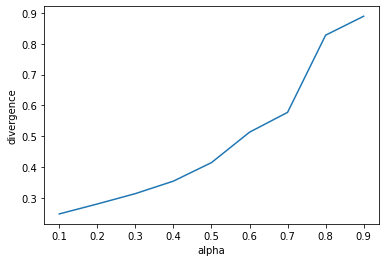

In [9]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(alpha_range, D_loss_vals[:,0])
plt.xlabel('alpha')
plt.ylabel('divergence')

(0.0, 2.5)

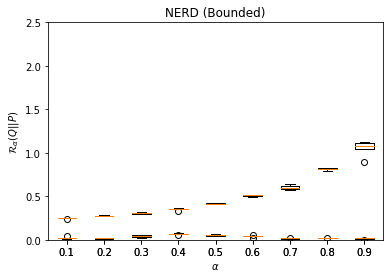

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], whis=2)
#ax1.plot(np.arange(1,len(alpha_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
ax1.boxplot(np.transpose(D_loss_vals_w_005[:,:]) , labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], whis=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 2.5)




In [ ]:
print('program terminated succesfully')